In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, min_cost_acceleration_factor
idx = pd.IndexSlice

with open(Path.cwd().parent / "config" / "config.yaml", "r") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]

In [2]:
root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep"

carrier_mapper = {
    "elec": "geothermal heat elec",
    "chp": "geothermal heat chp elec",
    "dh": "geothermal heat dh",
}


def get_data(mode, op, process=True):

    header = [4,5,6,7,8]
    index_cols = [0,1,2]

    """
    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            "nodal_capacities.csv", 
            index_col=index_cols, 
            header=header,
            )
    elif mode == "elec":
        df = pd.read_csv(
            root / f"{mode}_data" / "nodal_capacities.csv",
            index_col=index_cols,
            header=header,
            )
    """

    df = pd.read_csv(
        root /
        "joint_data" /
        "nodal_capacities.csv", 
        index_col=index_cols, 
        header=header,
        )
    
    df = df.loc[:,idx[:,mode,op]]
    
    if process:

        df.index = df.index.droplevel(0)
        df = df.loc[idx[:, carrier_mapper[mode]], idx[:,:,op]]

        df.index = df.index.get_level_values(0)
        df.columns = df.columns.get_level_values(0)

    df = df.loc[:, idx[:,:, "static"]]
    df = df.loc[~df.index.get_level_values(1).isna()]
    df.columns = df.columns.get_level_values(0)

    index = df.index.to_frame()
    index.index = index.index.get_level_values(2)
    df = df.groupby(level=2).sum()

    def get_component(carrier):
        value = index.loc[carrier, 0]
        if isinstance(value, str):
            return value
        else:
            return value.values[0]

    df.index = pd.MultiIndex.from_tuples([(get_component(carrier), carrier) for carrier in df.index])

    return df


def get_high_cost():

    header = [4,5,6,7,8]
    index_cols = [0,1,2]

    df = pd.read_csv(
        root /
        "high_cost_comparison" /
        "nodal_capacities.csv", 
        index_col=index_cols, 
        header=header,
        )
    
    df = df.loc[:,idx[:,:,"static"]]
    holdcols = df.columns.get_level_values(1)

    df = df.loc[:, idx[:,:,"static"]]
    df = df.loc[~df.index.get_level_values(1).isna()]
    df.columns = df.columns.get_level_values(0)

    index = df.index.to_frame()
    index.index = index.index.get_level_values(2)
    df = df.groupby(level=2).sum()

    def get_component(carrier):
        value = index.loc[carrier, 0]
        if isinstance(value, str):
            return value
        else:
            return value.values[0]

    df.index = pd.MultiIndex.from_tuples([(get_component(carrier), carrier) for carrier in df.index])
    df.columns = holdcols

    return df


df = get_data("chp", "static", process=False)

base_adoption = get_high_cost()

In [3]:
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

drop_thresholds = {
    "generators": 0.1,
    "links": 0.1,
    "stores": 10,
}

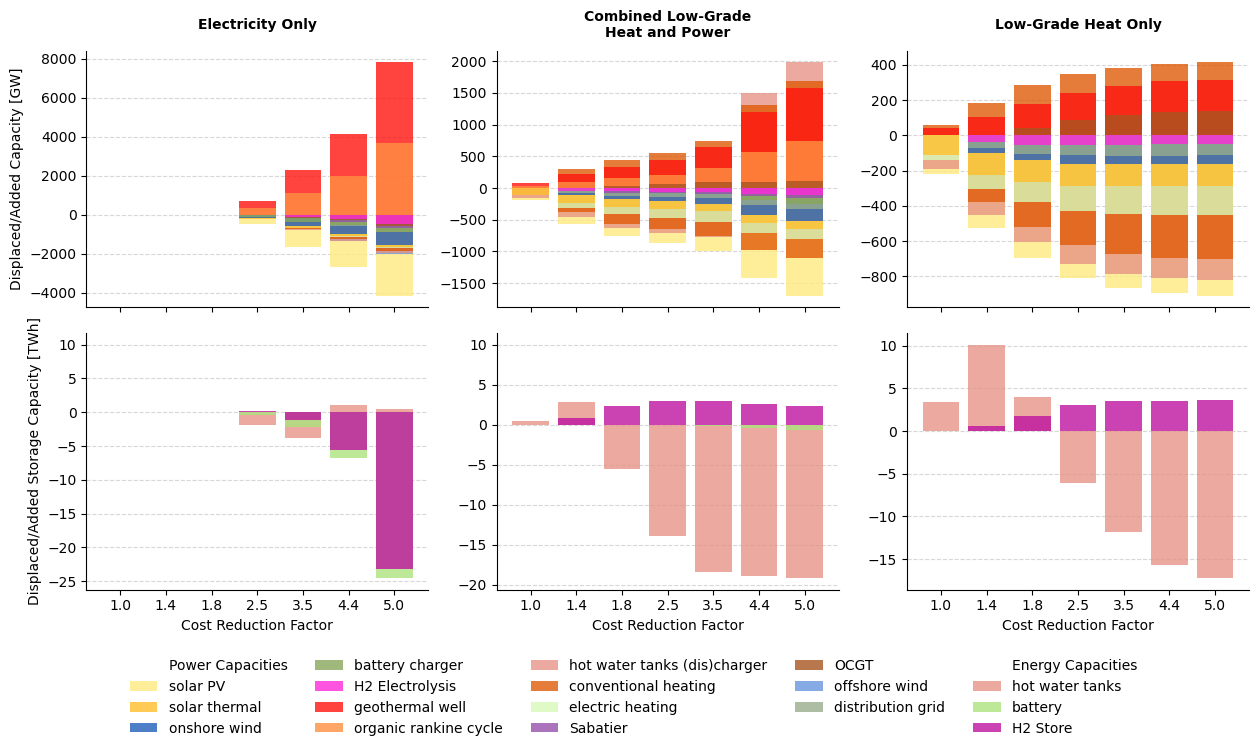

In [4]:
cap_threshold = 20 # GW
energy_threshold = 0.1 # TWh

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

def maybe_add(elements, new_element):
    
        for element in elements:
            if element.get_label() == new_element.get_label():
                return

        elements.append(new_element)

bar_kwargs = {
    "alpha": 0.8,
}

drops = [
    "injection geothermal heat",
    "geothermal heat dh",
    "geothermal heat chp dh",
    ]
renames = {
    "production geothermal heat": "geothermal well",
    "electricity distribution grid": "distribution grid",
    "urban central solar thermal": "solar thermal",
    "geothermal heat elec": "organic rankine cycle",
    "geothermal heat chp elec": "organic rankine cycle",
    "onwind": "onshore wind",
}
groups = {
    "electric heating": [
        "urban central resistive heater",
        "urban central air heat pump",
        "residential urban decentral air heat pump",
        "services urban decentral resistive heater",
        "services rural resistive heater",
        "residential urban decentral resistive heater",
        "residential rural resistive heater",
    ],
    "conventional heating": [
        "urban central gas CHP",
        "urban central gas boiler",
        "urban central solid biomass CHP CC",
        "services urban decentral gas boiler",
        "residential urban decentral gas boiler",
        "services urban decentral biomass boiler",
        "residential urban decentral biomass boiler",
        "residential rural gas boiler",
    ],
    "hot water tanks": [
        "urban central water tanks",
        "services urban decentral water tanks",
        "residential urban decentral water tanks",
        "residential rural water tanks",
    ],
    "hot water tanks (dis)charger": [
        "urban central water tanks charger",
        "residential urban decentral water tanks (dis)charger",
        "services urban decentral water tanks charger",
        "services rural water tanks charger",
        "residential rural water tanks charger",
    ],
    "offshore wind": [
        "offwind-ac",
        "offwind-dc",
    ],
    "solar PV": [
        "solar rooftop",
        "solar",
    ]

}


def prepare_cap(cap, drops, renames, groups):
    cap = cap.drop(cap.index.intersection(drops))

    cap.index = [renames.get(name, name) for name in cap.index]

    for group, members in groups.items():
        
        if not len(cap.index.intersection(members)):
            continue

        inter = cap.index.intersection(members)
        cap.loc[group] = cap.loc[inter].sum()
        cap = cap.drop(inter)
    
    return cap


cap_legend = [
    Patch(facecolor="white", label="Power Capacities"),
    ]
energy_legend = [
    Patch(facecolor="white", label=""),
    Patch(facecolor="white", label="Energy Capacities"),
]

for j, app in enumerate(["elec", "chp", "dh"]):

    df = get_data(app, "static", process=False)

    # base_col = df.columns[0]
    base = base_adoption.loc[:,app]

    # diff = df.subtract(df[base_col], axis=0).drop(base_col, axis=1)
    diff = df.subtract(base, axis=0)

    # for col in df.columns[1:]:
    for col in df.columns:

        cap = diff.loc[diff.index.get_level_values(0).isin(["generators", "links"]), col].mul(1e-3)
        energy = diff.loc[idx["stores", :], col].mul(1e-6)

        col = str(int(col) + min_cost_acceleration_factor)

        cap = cap[cap.abs() > cap_threshold]
        cap.index = cap.index.droplevel(0)

        cap = cap.loc[~cap.index.str.contains("discharger")]
        renamer = {name: name for name in cap.index}
        renamer.update(
            {"residential urban decentral water tanks charger": "residential urban decentral water tanks (dis)charger"}
        )
        cap.index = [renamer[name] for name in cap.index]

        cap_neg = cap[cap < 0]
        cap_pos = cap[cap > 0]

        cap_neg = prepare_cap(cap_neg, drops, renames, groups)
        cap_pos = prepare_cap(cap_pos, drops, renames, groups)

        cap_neg = cap_neg.cumsum()
        cap_pos = cap_pos.cumsum()

        if not cap_neg.empty:
            for i, (name, value) in enumerate(cap_neg.iloc[::-1].items()):
                axs[0,j].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
                maybe_add(cap_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))

        else:
            axs[0,j].bar(str(col), 0)

        if not cap_pos.empty:

            for i, (name, value) in enumerate(cap_pos.iloc[::-1].items()):
                axs[0,j].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
                maybe_add(cap_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))

        else:
            axs[0,j].bar(str(col), 0)

        energy = energy[energy.abs() > energy_threshold]
        energy = energy.loc[idx["stores"]]#, ["urban central water tanks"]]]
        energy = energy.loc[~energy.index.isin(["gas", "oil", "methanol"])]

        energy_neg = energy[energy < 0]
        energy_pos = energy[energy > 0]

        energy_neg = prepare_cap(energy_neg, drops, renames, groups)
        energy_pos = prepare_cap(energy_pos, drops, renames, groups)

        energy_neg = energy_neg.cumsum()
        energy_pos = energy_pos.cumsum()

        if not energy_neg.empty:

            for i, (name, value) in enumerate(energy_neg.iloc[::-1].items()):
                axs[1,j].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
                maybe_add(energy_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))
        
        else:
            axs[1,j].bar(str(col), 10, alpha=0.)

        if not energy_pos.empty:

            for i, (name, value) in enumerate(energy_pos.iloc[::-1].items()):
                axs[1,j].bar(str(col), value, bottom=0, label=name, color=tech_colors[name], **bar_kwargs)
                maybe_add(energy_legend, Patch(facecolor=tech_colors[name], label=name, **bar_kwargs))


axs[1,1].legend(
    handles=cap_legend + energy_legend,
    loc='upper center',
    bbox_to_anchor=(0.4, -0.22),
    # fancybox=True,
    frameon=False,
    # shadow=False,
    ncol=5,
    )

for ax in axs.flatten():
    ax.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

for ax in axs[0]:
    ax.set_xticklabels([])

for ax in axs[1]:
    # ax.set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))
    ax.set_xlabel("Cost Reduction Factor")
    ax.set_xticks(
        # [2025, 2030, 2035, 2040, 2045, 2050],
        [_ for _ in range(7)],
        ['1.0', '1.4', '1.8', '2.5', '3.5', '4.4', '5.0']
        )

axs[0,0].set_ylabel("Displaced/Added Capacity [GW]")
axs[1,0].set_ylabel("Displaced/Added Storage Capacity [TWh]")

texts = ["Electricity Only", "Combined Low-Grade\nHeat and Power", "Low-Grade Heat Only"]
for i, ax in enumerate(axs[0]):
    ax.text(
        0.5,
        1.1,
        texts[i],
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        weight="bold",
        )

# for ax in axs[1]:
    # fig.autofmt_xdate(rotation=45)

plt.subplots_adjust(hspace=0.1)

plt.savefig("displaced_capacities.pdf", bbox_inches="tight")
plt.show()